In [1]:
from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from torchray_extremal_perturbation_smaller_blur import extremal_perturbation, contrastive_reward, simple_reward
#from torchray.benchmark import get_example_data, plot_example
from torchray.utils import get_device

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import tensorflow as tf
from tensorflow.keras.datasets import mnist


In [2]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


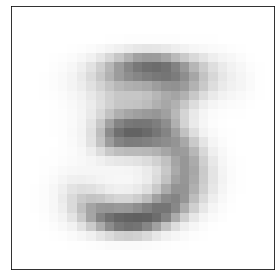

In [3]:
#Visualize background image distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 3)) + pseudo_count) / (x_train.shape[0] + pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_mean, cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


In [4]:
#Load predictor model

class CNNClassifier(nn.Module) :
    
    def __init__(self) :
        super(CNNClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(0, 0))
        self.act1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(0, 0))
        self.act2 = nn.ReLU()
        
        self.maxpool2 = nn.MaxPool2d((2, 2))
        self.drop2 = nn.Dropout(p=0.25)
        
        self.fc3 = nn.Linear(in_features=9216, out_features=128)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.5)
        
        self.fc4 = nn.Linear(in_features=128, out_features=10)
        #self.act4 = nn.Softmax(dim=1)
        
        self.use_cuda = True if torch.cuda.is_available() else False
        
    def forward(self, x):
        
        x = x.transpose(2, 3)
        
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        
        x = self.drop2(self.maxpool2(x))
        
        x = x.transpose(1, 3)
        x = x.reshape(-1, 9216)
        x = self.drop3(self.act3(self.fc3(x)))
        
        #y = self.act4(self.fc4(x))
        y = self.fc4(x)
        
        return y


model_pytorch = CNNClassifier()
_ = model_pytorch.load_state_dict(torch.load("saved_models/mnist_binarized_cnn_10_digits_pytorch.pth"))


In [5]:
#Create pytorch input tensor

x_test_pytorch = Variable(torch.FloatTensor(np.transpose(x_test, (0, 3, 1, 2))))
x_test_pytorch = x_test_pytorch.cuda() if model_pytorch.use_cuda else x_test_pytorch

digit_test = np.array(np.argmax(y_test, axis=1), dtype=np.int)


In [6]:
#Predict using pytorch model
device = get_device()

model_pytorch.to(device)

model_pytorch.eval()

y_pred_pytorch = model_pytorch(x_test_pytorch).data.cpu().numpy()

digit_pred_test = np.argmax(y_pred_pytorch, axis=-1)

print("Test accuracy = " + str(round(np.sum(digit_test == digit_pred_test) / digit_test.shape[0], 4)))


Test accuracy = 0.9936


In [7]:

device = get_device()

model_pytorch.to(device)
x_test_pytorch = x_test_pytorch.to(device)


In [8]:
#Execute method on test set

n_to_test = 200#x_test.shape[0]

area = 0.1
variant_mode = "preserve"
perturbation_mode = "blur"

masks = []

for i in range(n_to_test) :
    if i % 100 == 0 :
        print("Processing example " + str(i) + "...")
    
    m, _ = extremal_perturbation(
        model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
        reward_func=contrastive_reward,
        debug=False,
        jitter=False,
        areas=[area],
        variant=variant_mode,
        perturbation=perturbation_mode,
        num_levels=8,
        step=3,
        sigma=5
    )
    
    masks.append(np.expand_dims(m.cpu().numpy()[:, 0, ...], axis=-1))

importance_scores_test = np.concatenate(masks, axis=0)


Processing example 0...
Processing example 100...


Test image 0:


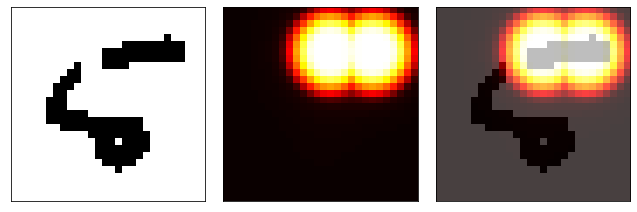

Test image 1:


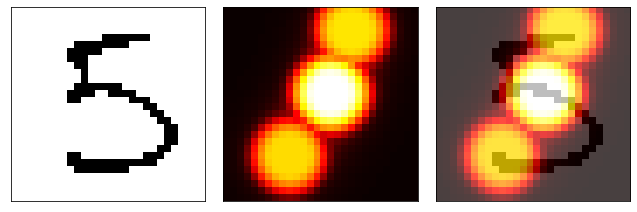

Test image 2:


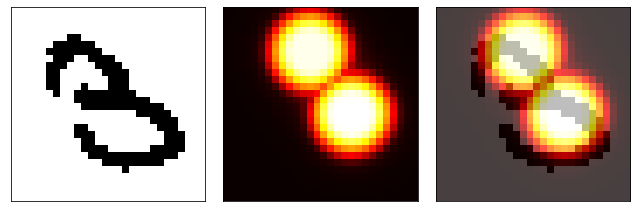

Test image 3:


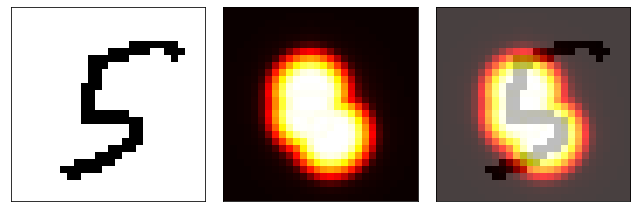

Test image 4:


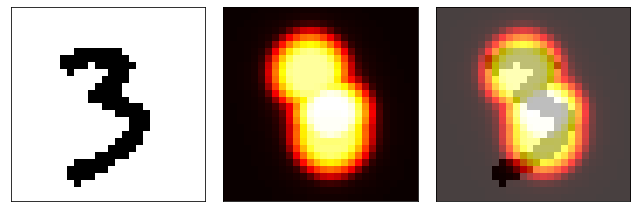

Test image 5:


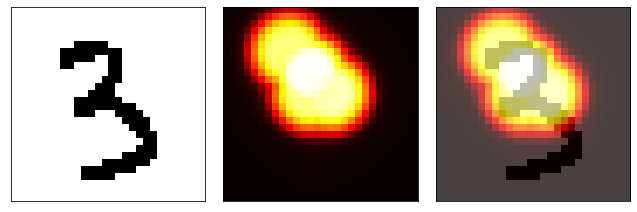

Test image 6:


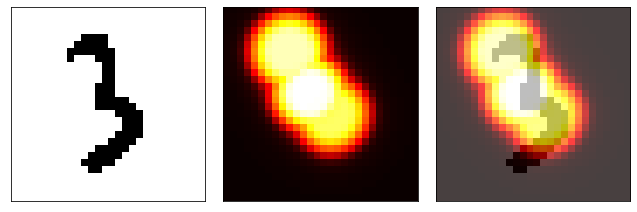

Test image 7:


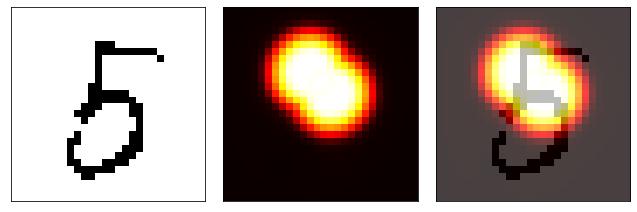

Test image 8:


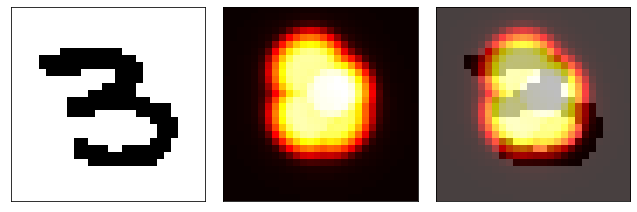

Test image 9:


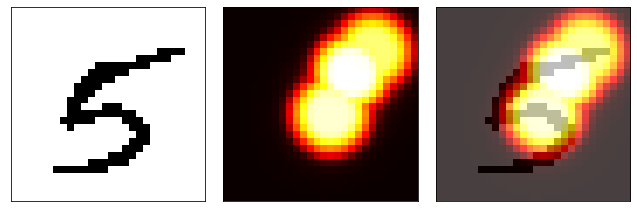

Test image 10:


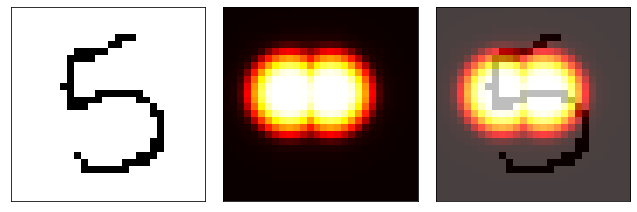

Test image 11:


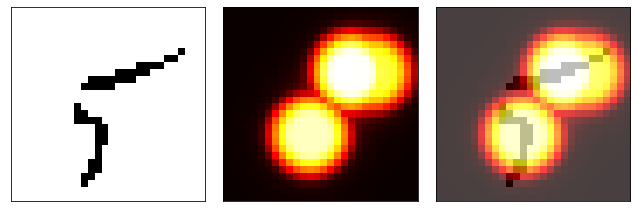

Test image 12:


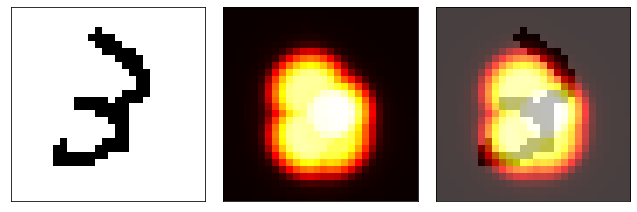

Test image 13:


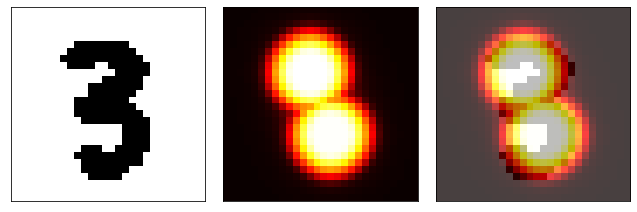

Test image 14:


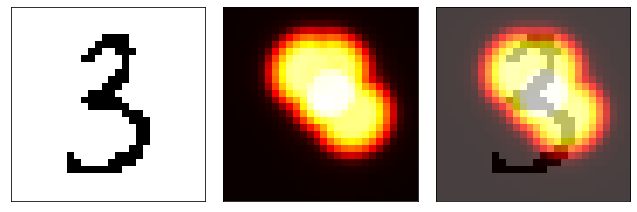

Test image 15:


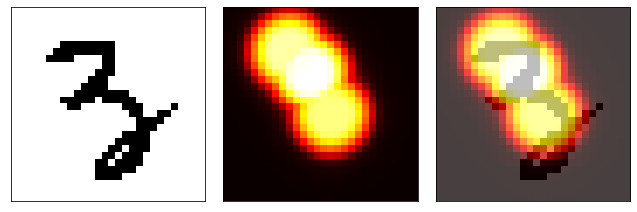

Test image 16:


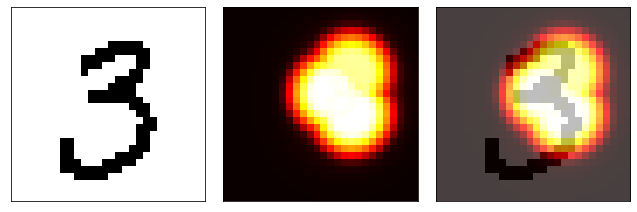

Test image 17:


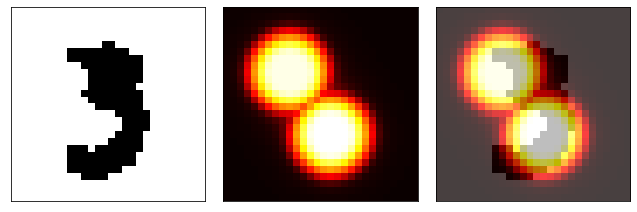

Test image 18:


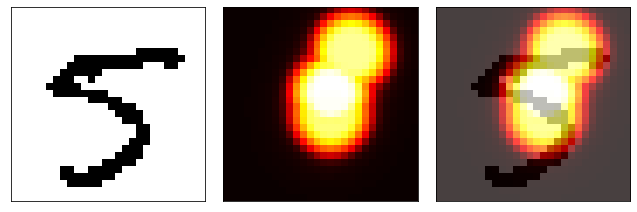

Test image 19:


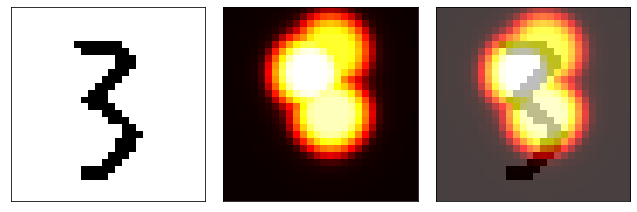

In [9]:
#Visualize a few images

for plot_i in range(0, 20) :
    
    print("Test image " + str(plot_i) + ":")
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


In [10]:
#Save predicted importance scores

model_name = "extremal_" + dataset_name + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")

np.save(model_name + "_importance_scores_test", importance_scores_test)


In [11]:
#Execute method on test set

n_to_test = 200#x_test.shape[0]

area = 0.1
variant_mode = "preserve"
perturbation_mode = "fade"

masks = []

for i in range(n_to_test) :
    if i % 100 == 0 :
        print("Processing example " + str(i) + "...")
    
    m, _ = extremal_perturbation(
        model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
        reward_func=contrastive_reward,
        debug=False,
        jitter=False,
        areas=[area],
        variant=variant_mode,
        perturbation=perturbation_mode,
        num_levels=8,
        step=3,
        sigma=5
    )
    
    masks.append(np.expand_dims(m.cpu().numpy()[:, 0, ...], axis=-1))

importance_scores_test = np.concatenate(masks, axis=0)


Processing example 0...
Processing example 100...


Test image 0:


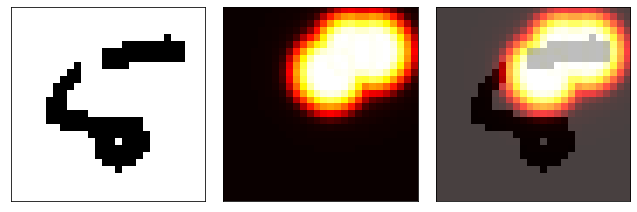

Test image 1:


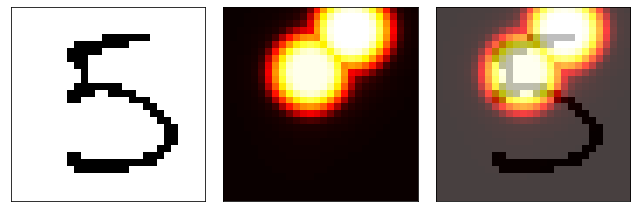

Test image 2:


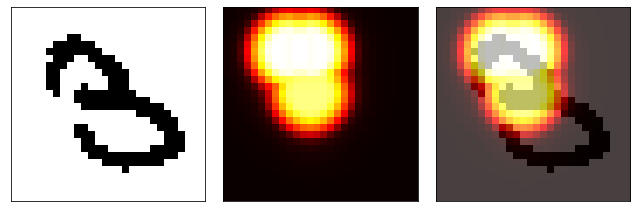

Test image 3:


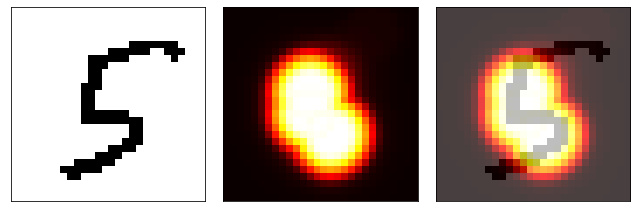

Test image 4:


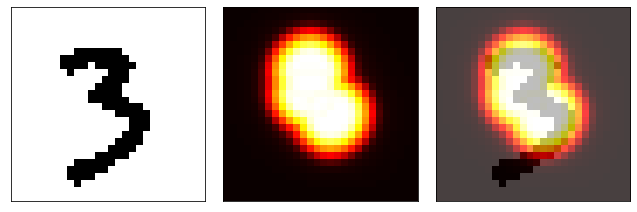

Test image 5:


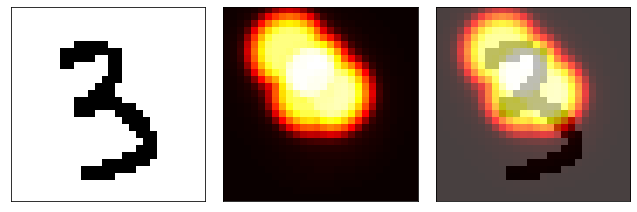

Test image 6:


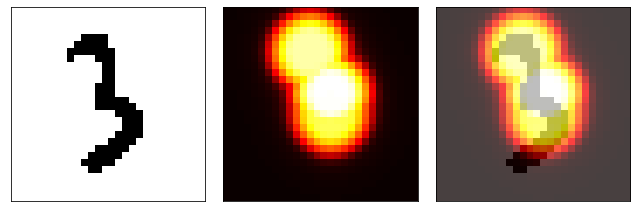

Test image 7:


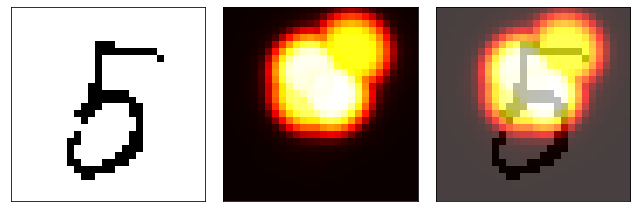

Test image 8:


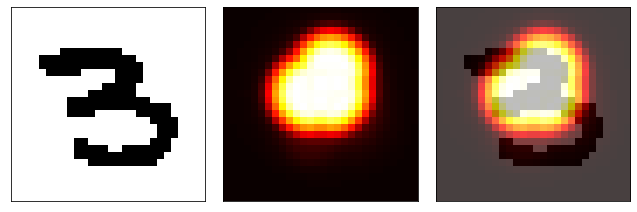

Test image 9:


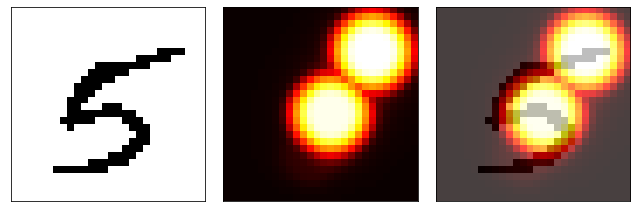

Test image 10:


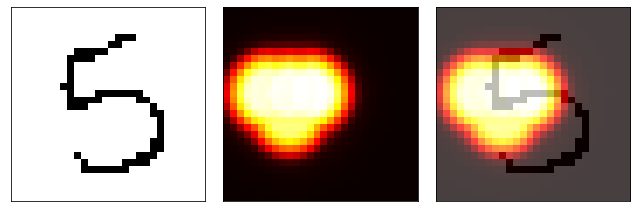

Test image 11:


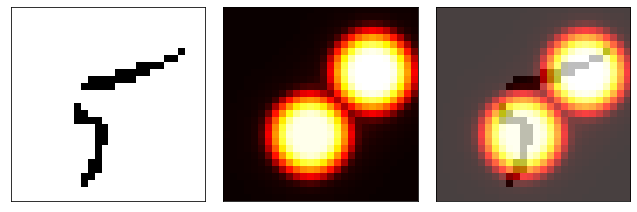

Test image 12:


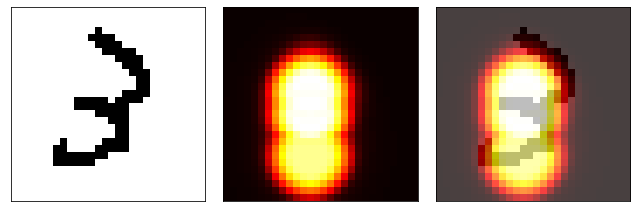

Test image 13:


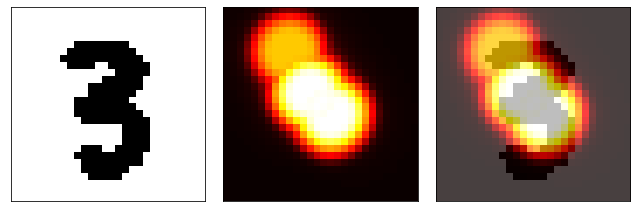

Test image 14:


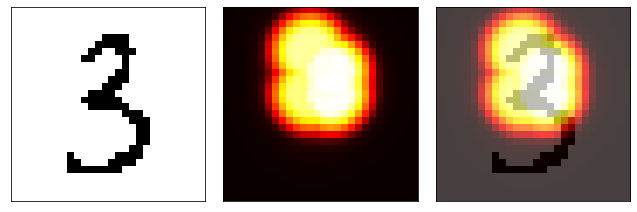

Test image 15:


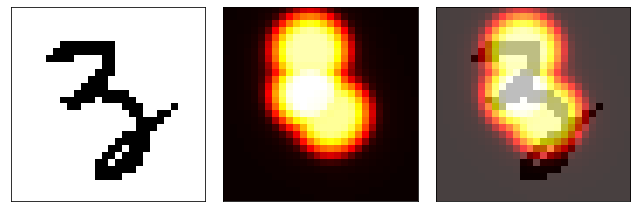

Test image 16:


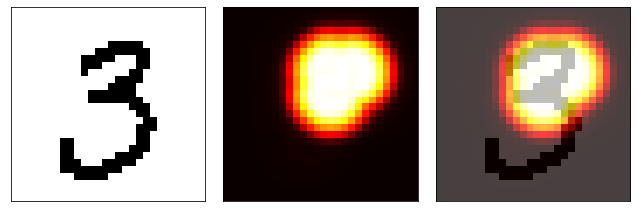

Test image 17:


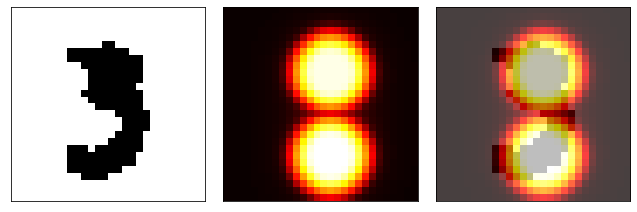

Test image 18:


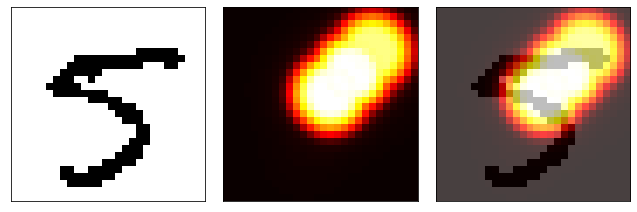

Test image 19:


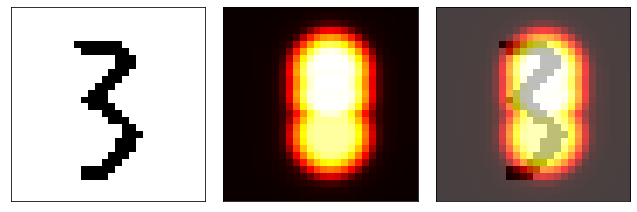

In [12]:
#Visualize a few images

for plot_i in range(0, 20) :
    
    print("Test image " + str(plot_i) + ":")
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


In [13]:
#Save predicted importance scores

model_name = "extremal_" + dataset_name + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")

np.save(model_name + "_importance_scores_test", importance_scores_test)


In [14]:
#Execute method on test set

n_to_test = 200#x_test.shape[0]

area = 0.1
variant_mode = "delete"
perturbation_mode = "blur"

masks = []

for i in range(n_to_test) :
    if i % 100 == 0 :
        print("Processing example " + str(i) + "...")
    
    m, _ = extremal_perturbation(
        model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
        reward_func=contrastive_reward,
        debug=False,
        jitter=False,
        areas=[area],
        variant=variant_mode,
        perturbation=perturbation_mode,
        num_levels=8,
        step=3,
        sigma=5
    )
    
    masks.append(np.expand_dims(m.cpu().numpy()[:, 0, ...], axis=-1))

importance_scores_test = np.concatenate(masks, axis=0)


Processing example 0...
Processing example 100...


Test image 0:


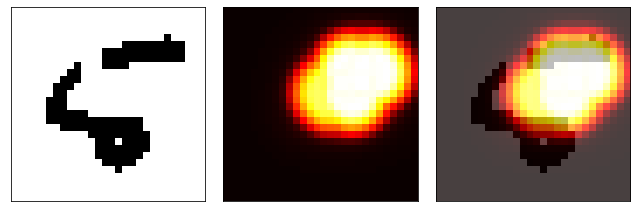

Test image 1:


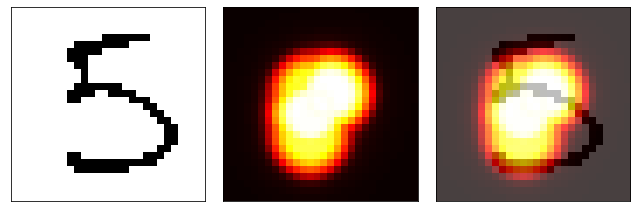

Test image 2:


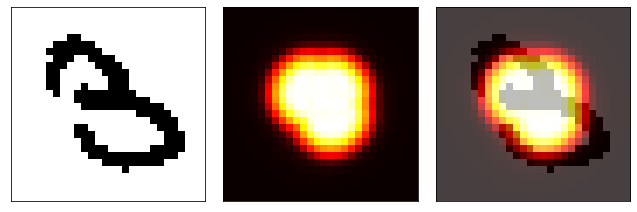

Test image 3:


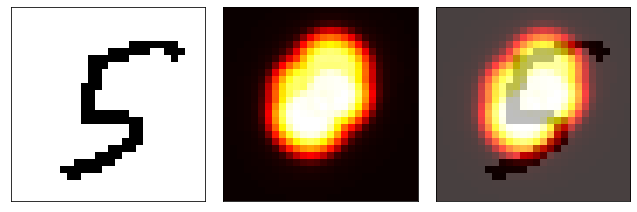

Test image 4:


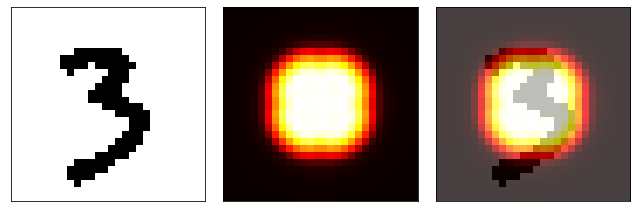

Test image 5:


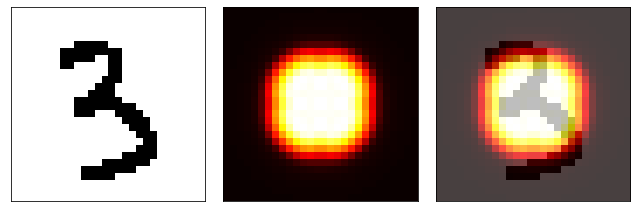

Test image 6:


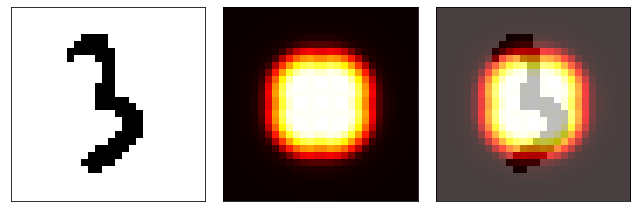

Test image 7:


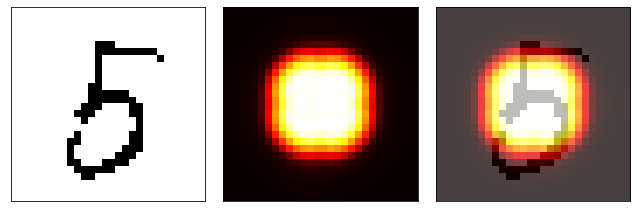

Test image 8:


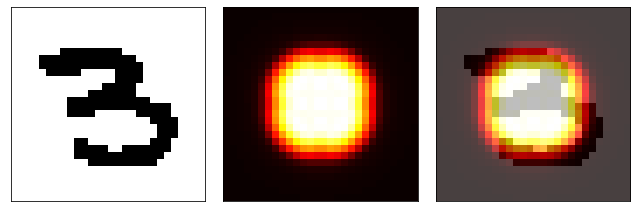

Test image 9:


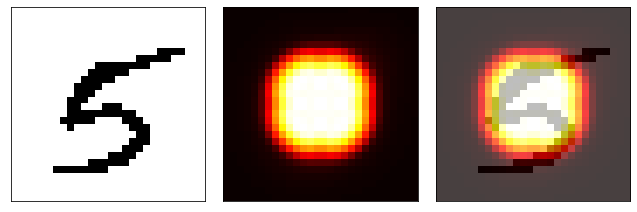

Test image 10:


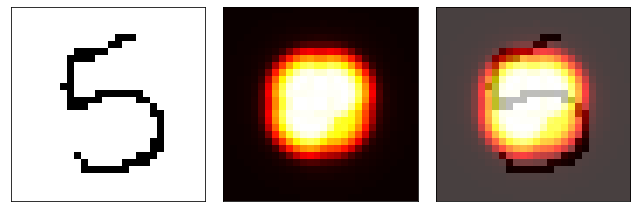

Test image 11:


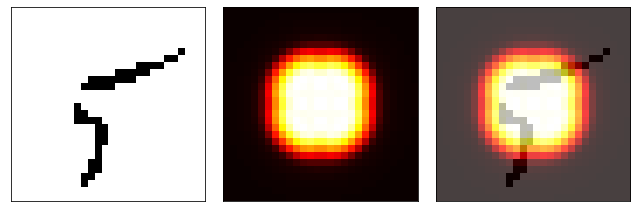

Test image 12:


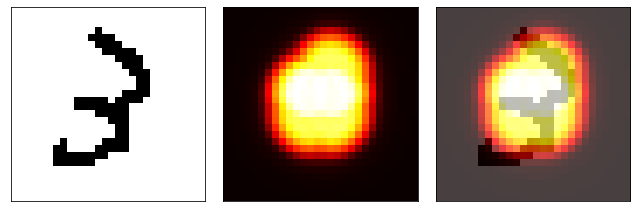

Test image 13:


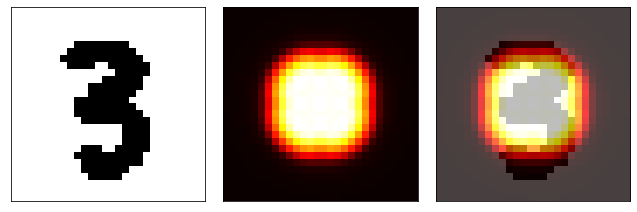

Test image 14:


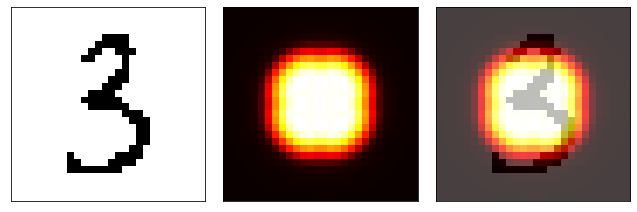

Test image 15:


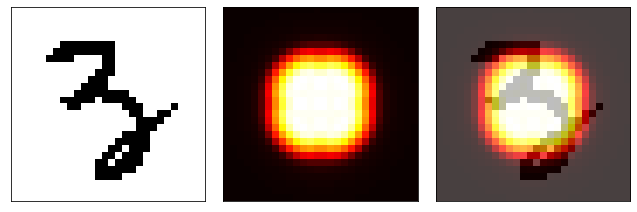

Test image 16:


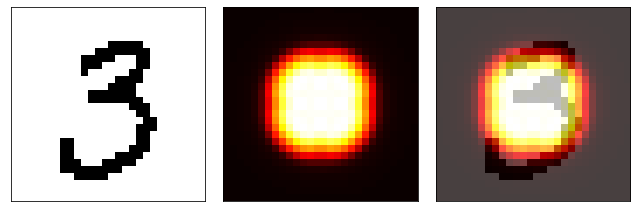

Test image 17:


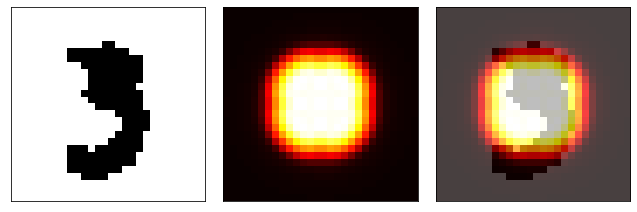

Test image 18:


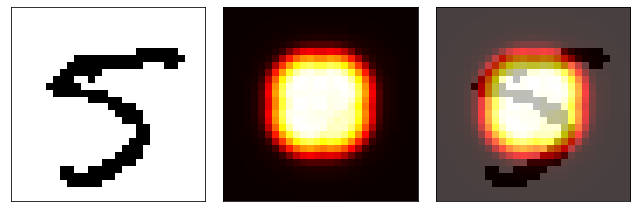

Test image 19:


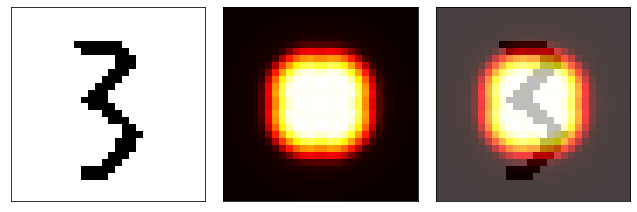

In [15]:
#Visualize a few images

for plot_i in range(0, 20) :
    
    print("Test image " + str(plot_i) + ":")
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


In [16]:
#Save predicted importance scores

model_name = "extremal_" + dataset_name + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")

np.save(model_name + "_importance_scores_test", importance_scores_test)


In [17]:
#Execute method on test set

n_to_test = 200#x_test.shape[0]

area = 0.1
variant_mode = "delete"
perturbation_mode = "fade"

masks = []

for i in range(n_to_test) :
    if i % 100 == 0 :
        print("Processing example " + str(i) + "...")
    
    m, _ = extremal_perturbation(
        model_pytorch, x_test_pytorch[i:i + 1], int(digit_test[i]),
        reward_func=contrastive_reward,
        debug=False,
        jitter=False,
        areas=[area],
        variant=variant_mode,
        perturbation=perturbation_mode,
        num_levels=8,
        step=3,
        sigma=5
    )
    
    masks.append(np.expand_dims(m.cpu().numpy()[:, 0, ...], axis=-1))

importance_scores_test = np.concatenate(masks, axis=0)


Processing example 0...
Processing example 100...


Test image 0:


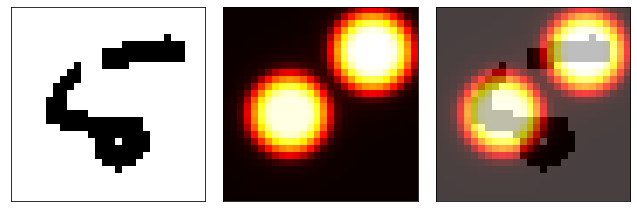

Test image 1:


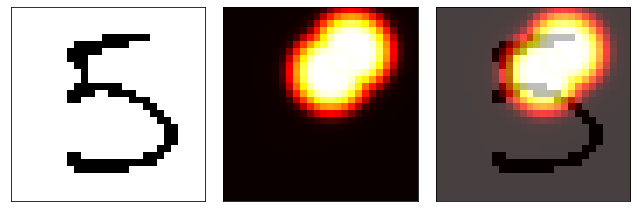

Test image 2:


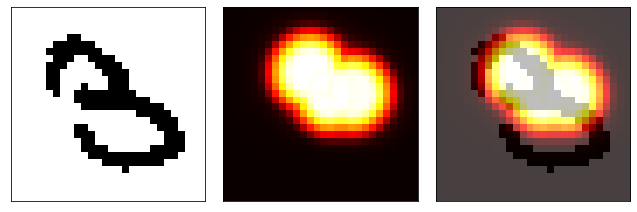

Test image 3:


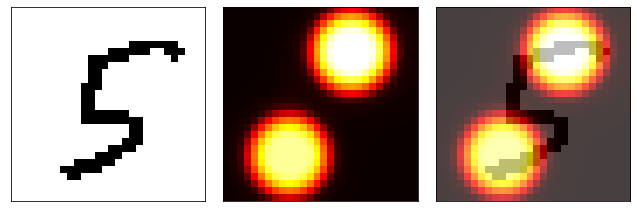

Test image 4:


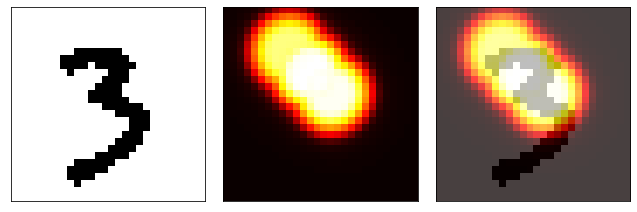

Test image 5:


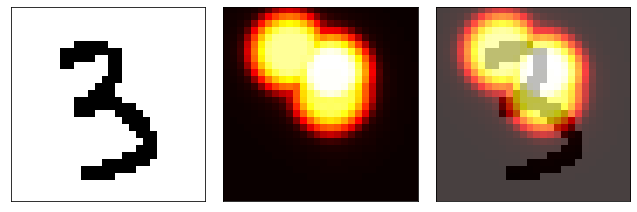

Test image 6:


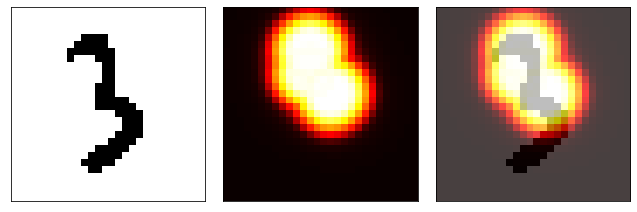

Test image 7:


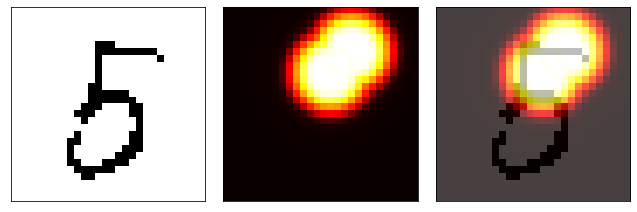

Test image 8:


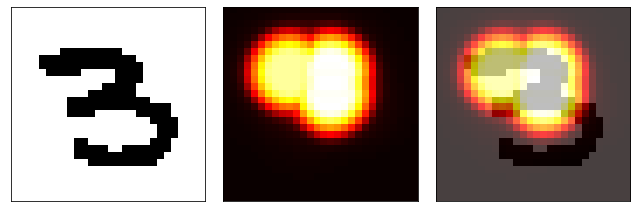

Test image 9:


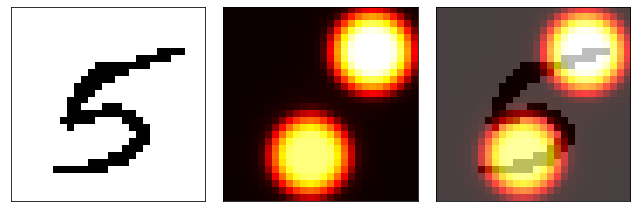

Test image 10:


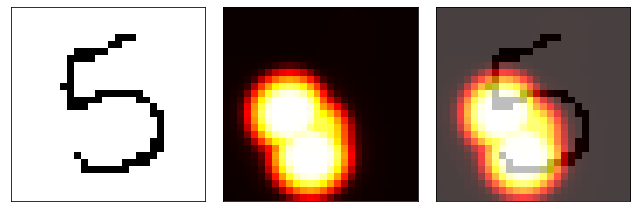

Test image 11:


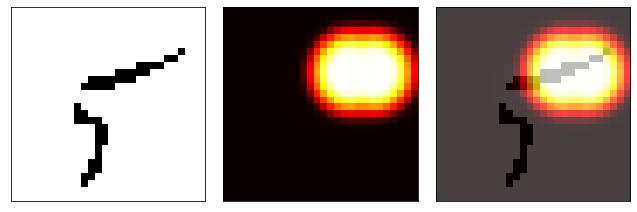

Test image 12:


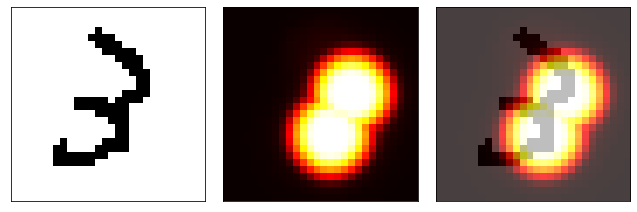

Test image 13:


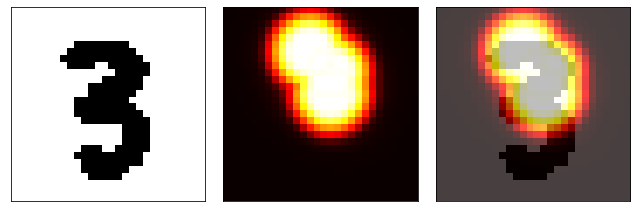

Test image 14:


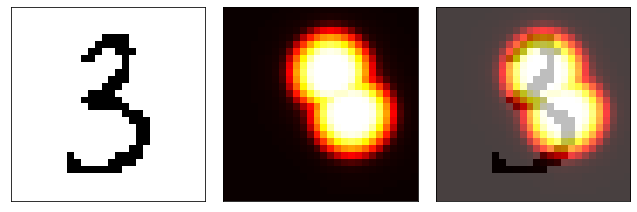

Test image 15:


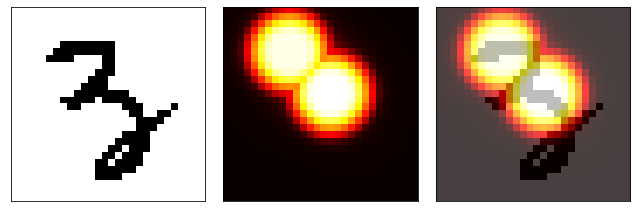

Test image 16:


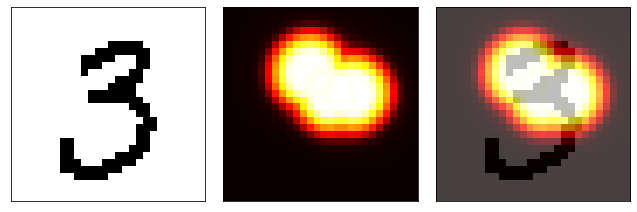

Test image 17:


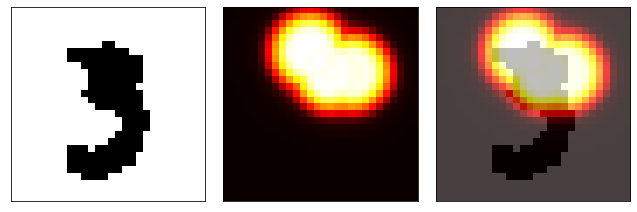

Test image 18:


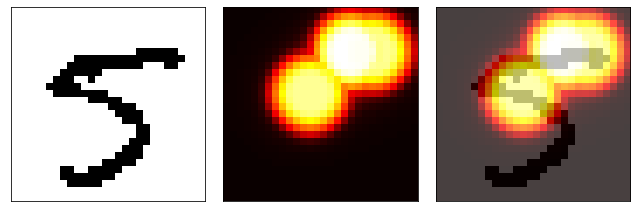

Test image 19:


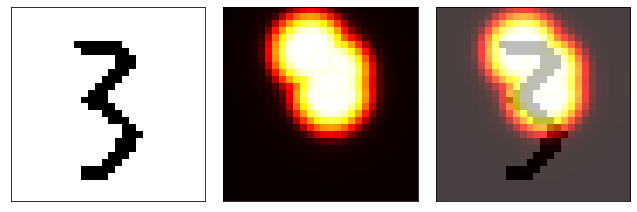

In [18]:
#Visualize a few images

for plot_i in range(0, 20) :
    
    print("Test image " + str(plot_i) + ":")
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


In [19]:
#Save predicted importance scores

model_name = "extremal_" + dataset_name + "_mode_" + variant_mode + "_perturbation_" + perturbation_mode + "_area_" + str(area).replace(".", "")

np.save(model_name + "_importance_scores_test", importance_scores_test)
